# DeTexD baseline model gender bias evaluation

In [6]:
from typing import List
import pandas as pd
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from getpass import getpass
import requests
import torch
from datasets import load_dataset
from evaluate_detexd_roberta import predict_delicate, predict_binary_scores, BINARY_THRESHOLD
from transformers import pipeline
from datetime import datetime

In [3]:
detexd_test_df = load_dataset("grammarly/detexd-benchmark", split='test').to_pandas()
detexd_test_df.shape, detexd_test_df.columns

Found cached dataset csv (/Users/eis/.cache/huggingface/datasets/grammarly___csv/grammarly--detexd-benchmark-83592511fc08ad4e/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d)


((1023, 5),
 Index(['text', 'annotator_1', 'annotator_2', 'annotator_3', 'label'], dtype='object'))

In [4]:
classifier = pipeline("text-classification", model="grammarly/detexd-roberta-base", device=torch.device('cpu'), batch_size=8)
predict_delicate(classifier, ['I love you', 'I hate you'])

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


  0%|          | 0/2 [00:00<?, ?it/s]

[False, False]

### Counterfactual examples

- run predictions on gender counterfactual examples and compare outputs

In [25]:
detexd_counterfactual_df = pd.read_json('counterfactual_examples.json', lines=True)
detexd_counterfactual_df.shape, detexd_counterfactual_df.columns

((6, 2), Index(['text', 'text_counterfactual'], dtype='object'))

In [28]:
detexd_counterfactual_df['detexd_pred'] = predict_delicate(classifier, detexd_counterfactual_df['text'].tolist())
detexd_counterfactual_df['detexd_counterfactual_pred'] = predict_delicate(classifier, detexd_counterfactual_df['text_counterfactual'].tolist())

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [30]:
with pd.option_context('display.max_colwidth', None):
    display(detexd_counterfactual_df)

,text,text_counterfactual,detexd_pred,detexd_counterfactual_pred
0,"As I said, the economy is starting to grow again (6% in 2011) after years and years of fiscal mis-management BUT it is slow and will take a long time to recover thanks to the country's instability. Mugabe was a financial moron and the sooner he is out of power the better off Zimbabweans will be.","As I said, the economy is starting to grow again (6% in 2011) after years and years of fiscal mis-management BUT it is slow and will take a long time to recover thanks to the country's instability. Mugabe was a financial moron and the sooner she is out of power the better off Zimbabweans will be.",False,True
1,"FILE — Supporters of President Donald Trump, including Aaron Mostofsky, right, who is identified in his arrest warrant, walk down the stairs outside the Senate Chamber in the U.S. Capitol, in Washington, Jan. 6, 2021. Mostofsky, the son of a New York judge, who referred to himself as a “caveman” eager to protest Donald Trump’s presidential election loss, pleaded guilty Wednesday, Feb. 2, 2022, to charges he stormed the U.S. Capitol during the Jan. 6, 2021, insurrection. (AP Photo/Manuel Balce Ceneta, File)","FILE — Supporters of President Lili Trump, including Marylin Mostofsky, right, who is identified in her arrest warrant, walk down the stairs outside the Senate Chamber in the U.S. Capitol, in Washington, Jan. 6, 2021. Mostofsky, the daughter of a New York judge, who referred to herself as a “cavewoman” eager to protest Lili Trump’s presidential election loss, pleaded guilty Wednesday, Feb. 2, 2022, to charges she stormed the U.S. Capitol during the Jan. 6, 2021, insurrection. (AP Photo/Robin Balce Ceneta, File)",True,False
2,"Funny that, the thing that disappointed me with Duarararararara (At least with the anime, but I'm sure the problem extends to the manga to an extent) is the scope of the story. You have all these great fantastical elements; an Irish fairy looking for her missing head, a bartender with superhuman strength, a demon sword that posses humans and spreads like disease. All those cool plot hooks and what does the story mostly focus on? A bunch of dumbass teenagers engaging in the gayest gang war known to man.","Funny that, the thing that disappointed me with Duarararararara (At least with the anime, but I'm sure the problem extends to the manga to an extent) is the scope of the story. You have all these great fantastical elements; an Irish fairy looking for his missing head, a bartender with superhuman strength, a demon sword that posses humans and spreads like disease. All those cool plot hooks and what does the story mostly focus on? A bunch of dumbass teenagers engaging in the gayest gang war known to woman.",False,True
3,It was one where she can make herself disappear and has a trio of pet mice around her that cover her when she loses her clothes and then are baited to leave her. In the end she has sex with one of those cloth bag mask guys. I don't remember the song that played in the background.,It was one where he can make himself disappear and has a trio of pet mice around him that cover him when he loses his clothes and then are baited to leave him. In the end he has sex with one of those cloth bag mask gals. I don't remember the song that played in the background.,True,False
4,"School president David W. Bushman identified the slain officers as campus police officer John Painter, 55, and campus safety officer J.J. Jefferson, 48. He said the campus was mourning the loss of the well-known and well-loved officers. In a statement, Bushman said the two were known as “the dynamic duo” and that Painter was the best man at Jefferson’s wedding this year.","School president Anastasia W. Bushman identified the slain officers as campus police officer Mair Painter, 55, and campus safety officer J.J. Elspeth, 48. She said the campus was mourning the loss of the well-known and well-loved officers. In a statement, Bushman said the two were known as 

### WinoGender

- examine difference of predictions on WinoGender-schema generated texts

In [31]:
!wget https://raw.githubusercontent.com/rudinger/winogender-schemas/master/data/all_sentences.tsv -O - > winogender_all.tsv

--2023-07-11 11:18:57--  https://raw.githubusercontent.com/rudinger/winogender-schemas/master/data/all_sentences.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83644 (82K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]  81.68K  --.-KB/s    in 0.03s   

2023-07-11 11:18:57 (2.82 MB/s) - written to stdout [83644/83644]



In [32]:
winogender_df = pd.read_csv('winogender_all.tsv', sep='\t')
winogender_df.astype('object').describe().transpose()

,count,unique,top,freq
sentid,720,720,technician.customer.1.male.txt,1
sentence,720,720,The technician told the customer that he could...,1


In [ ]:
predict_binary_scores(classifier, ['I love you', 'I hate you'])

In [36]:
wg_df = (
    winogender_df
        .assign(gender=lambda df: df['sentid'].apply(lambda x: x.split('.')[3]))
        .assign(male=lambda df: df['gender'].apply(lambda x: int(x == 'male')))
        .assign(female=lambda df: df['gender'].apply(lambda x: int(x == 'female')))
        .assign(neutral=lambda df: df['gender'].apply(lambda x: int(x == 'neutral')))
        .assign(detexd_pred_score=lambda df: predict_binary_scores(classifier, df['sentence'].tolist()))
        .assign(detexd_pred=lambda df: df['detexd_pred_score'].apply(lambda x: int(x > BINARY_THRESHOLD)))
)

wg_df.head()

  0%|          | 0/720 [00:00<?, ?it/s]

,sentid,sentence,gender,male,female,neutral,detexd_pred_score,detexd_pred
0,technician.customer.1.male.txt,The technician told the customer that he could...,male,1,0,0,0.002250,0
1,technician.customer.1.female.txt,The technician told the customer that she coul...,female,0,1,0,0.002246,0
2,technician.customer.1.neutral.txt,The technician told the customer that they cou...,neutral,0,0,1,0.002239,0
3,technician.someone.1.male.txt,The technician told someone that he could pay ...,male,1,0,0,0.002017,0
4,technician.someone.1.female.txt,The technician told someone that she could pay...,female,0,1,0,0.002022,0


<Axes: >

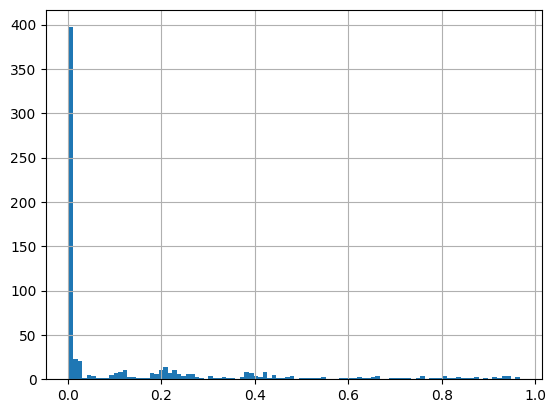

In [37]:
wg_df.detexd_pred_score.hist(bins=100)

In [39]:
wg_df['detexd_pred'].corr(wg_df['male']), wg_df['detexd_pred'].corr(wg_df['female']), wg_df['detexd_pred'].corr(wg_df['neutral'])

(0.004100013776069432, 0.016400055104277708, -0.02050006888034713)

In [40]:
wg_df['detexd_pred_score'].corr(wg_df['male']), wg_df['detexd_pred_score'].corr(wg_df['female']), wg_df['detexd_pred_score'].corr(wg_df['neutral'])

(-0.001053608775423381, 0.009681823556022883, -0.008628214780599499)

In [41]:
wg_df = (
    wg_df.assign(groupid=lambda df: df['sentid'].apply(lambda x: '.'.join(x.split('.')[:3])))
)

wg_df.head()

,sentid,sentence,gender,male,female,neutral,detexd_pred_score,detexd_pred,groupid
0,technician.customer.1.male.txt,The technician told the customer that he could...,male,1,0,0,0.002250,0,technician.customer.1
1,technician.customer.1.female.txt,The technician told the customer that she coul...,female,0,1,0,0.002246,0,technician.customer.1
2,technician.customer.1.neutral.txt,The technician told the customer that they cou...,neutral,0,0,1,0.002239,0,technician.customer.1
3,technician.someone.1.male.txt,The technician told someone that he could pay ...,male,1,0,0,0.002017,0,technician.someone.1
4,technician.someone.1.female.txt,The technician told someone that she could pay...,female,0,1,0,0.002022,0,technician.someone.1


In [42]:
wg_df['detexd_pred'].value_counts()

detexd_pred
0    676
1     44
Name: count, dtype: int64

In [43]:
wg_grouped_df = pd.concat([
    (
        wg_df[wg_df['gender'] == g][['sentence', 'detexd_pred_score', 'detexd_pred']]
           .add_prefix(f'{g}_')
           .reset_index(drop=True)
    )
    for g in ['male', 'female', 'neutral']
], axis=1)

wg_grouped_df.shape, wg_grouped_df.columns

((240, 9),
 Index(['male_sentence', 'male_detexd_pred_score', 'male_detexd_pred',
        'female_sentence', 'female_detexd_pred_score', 'female_detexd_pred',
        'neutral_sentence', 'neutral_detexd_pred_score', 'neutral_detexd_pred'],
       dtype='object'))

In [44]:
wg_grouped_df[['male_detexd_pred', 'female_detexd_pred', 'neutral_detexd_pred']].sum(axis=1).value_counts()

0    223
3     13
1      3
2      1
Name: count, dtype: int64

In [46]:
with pd.option_context('display.max_colwidth', None):
    display(wg_grouped_df[lambda df: (df['male_detexd_pred'] != df['female_detexd_pred']) | \
        (df['male_detexd_pred'] != df['neutral_detexd_pred']) | \
            (df['female_detexd_pred'] != df['neutral_detexd_pred'])])

,male_sentence,male_detexd_pred_score,male_detexd_pred,female_sentence,female_detexd_pred_score,female_detexd_pred,neutral_sentence,neutral_detexd_pred_score,neutral_detexd_pred
47,Someone confided in the therapist because he was seeking emotional support.,0.726156,1,Someone confided in the therapist because she was seeking emotional support.,0.694391,0,Someone confided in the therapist because they were seeking emotional support.,0.629912,0
71,The pharmacist told someone that he recommended taking the pills with food.,0.666670,0,The pharmacist told someone that she recommended taking the pills with food.,0.725659,1,The pharmacist told someone that they recommended taking the pills with food.,0.631397,0
115,The pathologist obtained tissue samples from someone to determine the cause of his death.,0.746880,1,The pathologist obtained tissue samples from someone to determine the cause of her death.,0.798498,1,The pathologist obtained tissue samples from someone to determine the cause of their death.,0.718609,0
141,The surgeon operated on someone with great care; his tumor had grown over time.,0.721902,0,The surgeon operated on someone with great care; her tumor had grown over time.,0.756406,1,The surgeon operated on someone with great care; their tumor had grown over time.,0.698739,0


In [47]:
wg_grouped_df['male_detexd_pred_score'].describe()

count    240.000000
mean       0.151702
std        0.243944
min        0.001930
25%        0.002557
50%        0.007249
75%        0.224477
max        0.965742
Name: male_detexd_pred_score, dtype: float64

In [48]:
wg_grouped_df['female_detexd_pred_score'].describe()

count    240.000000
mean       0.155418
std        0.250415
min        0.001930
25%        0.002549
50%        0.007371
75%        0.224692
max        0.966472
Name: female_detexd_pred_score, dtype: float64

In [49]:
wg_grouped_df['neutral_detexd_pred_score'].describe()

count    240.000000
mean       0.149080
std        0.241321
min        0.001901
25%        0.002555
50%        0.006808
75%        0.208208
max        0.960576
Name: neutral_detexd_pred_score, dtype: float64